# Ethiopia Mapping Section

This Python Jupyter file is to calculate and build out the requirements for the Ethiopian design. It could be possible to do this in Excel as well; but this way we have an ability to reference and redesign as per the changing requirements.

First Step is to collect the information; I have a Github account under my username (johnmeye) which i will reference from the file so that anyone who uses Conda/Jupyter will be able to get the files. For any challenges reach out to me on teams or by email (johnmeye@cisco.com)

In [1]:
from urllib.request import urlopen
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#For the Map Plotting
import plotly
import plotly.express as px

#Fo the Widgets
import ipywidgets as widgets #Importing Widgets to allow for the changing of variables on the fly as questions are asked.

## Geographical Data

This file below is from the Ethiopian files available from the database on the following site:
https://data.humdata.org/dataset/ethiopia-population-data-_-admin-level-0-3

This site has both topography and the Level 0-3 admin data on the population levels per county/province. Vodacom only provided at Admin 1 (Provincial level) for this RFQ; but we are able to go more in depth to try and work out if there is any additional information we can use to strengthen our position.

The following section will pull that information from my Github; so that you don't have to fetch it yourself. Then load it as a JSON file into the DB, which you can see are Polygon type files with GPS coordinates which mark out the different layers/levels in the country. 

If needed you can pull the information from the GeoJSON files as well, but i did include the boundaries data as a dataframe too. 
Example: counties3["features"][0]['properties'] #Just a sample on how to pull out specific information from the Counties json Files.

In [2]:
#Pull the Data I stored in my Github account for the analysis.

with urlopen('https://github.com/johnmeye/Ethiopia/raw/master/Ethiopia_JSON/eth_admbnda_adm1_csa_bofed_20190827.json') as response:
    counties1 = json.load(response)
    
with urlopen('https://github.com/johnmeye/Ethiopia/raw/master/Ethiopia_JSON/eth_admbnda_adm2_csa_bofed_20190827.json') as response:
    counties2 = json.load(response)
    
with urlopen('https://github.com/johnmeye/Ethiopia/raw/master/Ethiopia_JSON/eth_admbnda_adm3_csa_bofed_20190827.json') as response:
    counties3 = json.load(response)

#Feature Data is available in the JSON files but its easier to manage from a tableset so i have pulled this below as well.
    
Boundaries_Data1 = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/eth_adminboundaries_tabulardata.xlsx",
                  sheet_name='Admin1')

Boundaries_Data3 = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/eth_adminboundaries_tabulardata.xlsx",
                    sheet_name='Admin3')


## Admin Level Data

As mentioned above; there is both Geo and Admin data; this information matches the information against some paramater; since the file is nicely structured according to standards we will stick to the humanitarian markings. 

Below i read the information from different levels into the variables for Admin1-3 so that we are able to use them to draw choropleth maps of the country. 

Once read into memory; it is possible to find matches against the specific parameters in both the GeoJSON and the Admin files. So i run a few sample commands to view what the data looks like. 



In [3]:
Admin1 = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/ethiopia-population-data-_-admin-level-0-3.xlsx",
                   dtype={"admin1Pcode": str},
                   skiprows=[1],
                   sheet_name='Admin1')

Admin2 = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/ethiopia-population-data-_-admin-level-0-3.xlsx",
                   dtype={"admin1Pcode": str},
                   skiprows=[1],
                   sheet_name='Admin2')

Admin3 = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/ethiopia-population-data-_-admin-level-0-3.xlsx",
                   dtype={"admin1Pcode": str},
                   skiprows=[1],
                   sheet_name='Admin3')

# Plotting the information on a Choropleth map

This information that we have gathered above needs to be represented in order to accurately help. 

Vodacom has provided Admin 1 information so we will plot against the Admin1 codes in the information. 

I have made it all at different levels so that some code can run quicker if need be.

In [4]:
fig = px.choropleth_mapbox(Admin1, 
                           geojson=counties1, 
                           locations='admin1Pcode', featureidkey="properties.ADM1_PCODE",
                           color='Total Population',
                           color_continuous_scale="portland",
                           range_color=(500000, 30000000),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 9, "lon": 39},
                           opacity=0.5,
                           hover_name='admin1Name_en',
                           labels={
                            'Population_Density':'Population Density',
                            'Total_Population':'Total Population',
                            'admin1Name_en':'Province',
                            'Area_Km':'Square Kilometer'
                            },
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

plotly.offline.plot(fig, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\EthiopiaAdmin1.html')

'C:\\Users\\johnmeye\\Documents\\GitHub\\Ethiopia\\Plotly\\EthiopiaAdmin1.html'

# Manipulating the data to find the sites requirements

Vodacom has provided the Ethiopia site numbers, and the expected by year and by type, although the Vodacom breaks it down by height and rooftop; this might not be necessary from our point of view and should not impact the way we calculate this. 

For this we will need to figure out how to define rural/urban and so forth.

In [5]:
Sites = pd.read_excel("https://github.com/johnmeye/Ethiopia/raw/master/TX%20BoQ%20v3-Python.xlsx",
                   sheet_name='Site_Numbers')

Sites.rename(columns = {'Location':'admin1Name_en'}, inplace = True)
Site_Year = Sites.groupby(['admin1Name_en']).sum()
TotalSites = pd.merge(Site_Year, Boundaries_Data1[['admin1Name_en', 'Shape_Area']],how='left', on=['admin1Name_en']) #Site combined with the geodata. Sizing found early.
TotalSites.rename(columns = {'Shape_Area':'Shape_Area_Admin1'}, inplace = True)
TotalSites = TotalSites.drop(['Total'], axis=1)
TotalSites.loc['Year_Total']= TotalSites.sum(numeric_only=True, axis=0)
TotalSites.loc[:,'Total']= TotalSites.loc[:,'Year1':'Year11'].sum(numeric_only=True, axis=1)

TotalSites

,admin1Name_en,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Shape_Area_Admin1,Total
0,Addis Ababa,282.0,0.0,0.0,0.0,0.0,94.0,68.0,155.0,253.0,26.0,6.0,0.044369,884.0
1,Afar,61.0,2.0,3.0,37.0,43.0,26.0,68.0,30.0,67.0,22.0,72.0,7.879581,431.0
2,Amhara,364.0,422.0,271.0,133.0,61.0,258.0,226.0,204.0,207.0,354.0,411.0,12.901454,2911.0
3,Benishangul Gumz,28.0,0.0,2.0,21.0,29.0,36.0,38.0,34.0,48.0,3.0,32.0,4.149305,271.0
4,Dire Dawa,44.0,0.0,0.0,0.0,0.0,17.0,20.0,30.0,17.0,4.0,6.0,0.086757,138.0
5,Gambela,15.0,0.0,2.0,8.0,10.0,10.0,13.0,28.0,36.0,1.0,15.0,2.560910,138.0
6,Harari,32.0,0.0,0.0,2.0,0.0,3.0,8.0,23.0,16.0,0.0,13.0,0.030512,97.0
7,Oromia,231.0,412.0,495.0,518.0,461.0,481.0,400.0,415.0,443.0,541.0,766.0,26.474660,5163.0
8,SNNP,68.0,131.0,179.0,257.0,179.0,123.0,115.0,87.0,63.0,386.0,127.0,8.928528,1715.0
9,Somali,163.0,23.0,31.0,61.0,83.0,75.0,140.0,102.0,126.0,52.0,161.0,25.466707,1017.0


In [6]:
SiteTable = pd.merge(Admin3, TotalSites, how='outer', on=['admin1Name_en']) #Site by year
SiteTable.replace(to_replace=0, value=np.nan, inplace=True)
#Dropping a lot of information from Admin3 here to speed things up; we can return later if need be.
SiteTable.drop(SiteTable.iloc[:, 9:], inplace = True, axis = 1) 
SiteTable.drop(SiteTable.iloc[:, 6:8], inplace = True, axis = 1) 
SiteTable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 0 to 983
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   admin3Name_en     983 non-null    object 
 1   admin3Pcode       983 non-null    object 
 2   admin2Name_en     983 non-null    object 
 3   admin2Pcode       983 non-null    object 
 4   admin1Name_en     983 non-null    object 
 5   admin1Pcode       983 non-null    object 
 6   Total Population  982 non-null    float64
dtypes: float64(1), object(6)
memory usage: 61.5+ KB


In [7]:
Fulltable = pd.merge(SiteTable, Boundaries_Data3[['admin3Pcode', 'Shape_Area']],how='left', on=['admin3Pcode']) #Site combined with the geodata. Sizing found early.
Fulltable = Fulltable.dropna(subset=['admin3Name_en'])
Fulltable['Shape_Area'] = Fulltable['Shape_Area'].fillna(0)
Fulltable


,admin3Name_en,admin3Pcode,admin2Name_en,admin2Pcode,admin1Name_en,admin1Pcode,Total Population,Shape_Area
0,Tahtay Adiyabo,ET010101,North Western,ET0101,Tigray,ET01,104658.344988,0.322642
1,Laelay Adiabo,ET010102,North Western,ET0101,Tigray,ET01,127534.455026,0.150153
2,Medebay Zana,ET010103,North Western,ET0101,Tigray,ET01,146129.151842,0.087179
3,Tahtay Koraro,ET010104,North Western,ET0101,Tigray,ET01,77413.547199,0.055941
4,Asgede Tsimbila,ET010105,North Western,ET0101,Tigray,ET01,162416.356257,0.198092
...,...,...,...,...,...,...,...,...
978,Police Maret,ET150114,Dire Dawa urban,ET1501,Dire Dawa,ET15,4846.373489,0.000733
979,Aseliso,ET150201,Dire Dawa rural,ET1502,Dire Dawa,ET15,67673.068839,0.008446
980,Jeldessa,ET150206,Dire Dawa rural,ET1502,Dire Dawa,ET15,47375.035480,0.028006
981,Wahil,ET150207,Dire Dawa rural,ET1502,Dire Dawa,ET15,35409.185411,0.015083


### TODO: 
Plan is to create a dynamic image with the section below so that you can switch between the years and view what is happening.

In [8]:
#fig = px.choropleth_mapbox(Fulltable, 
#                           geojson=counties1, 
#                           locations='admin1Name_en', featureidkey="properties.ADM1_EN",
#                           color='Year1',
#                           color_continuous_scale="portland",
#                           range_color=(0, 350),
#                           mapbox_style="carto-positron",
#                           zoom=3, center = {"lat": 9, "lon": 39},
#                           opacity=0.5,
#                           
#                          )
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

# Calculating population density

The files provide a value for the size of the land and the overall land coverage. 1,104,300 square Km is the total size of the land in question. The following section shows the calculations used to determine the density for the various provinces. Which we are then able to use for the density and Rural/Urban calculations.

In [9]:
Ethiopia_Area = 1104300
Ethiopia_Shape_Area = Fulltable['Shape_Area'].sum()
print("Ethiopia Shape Area is:", Ethiopia_Shape_Area)
Unit_Area = Ethiopia_Area / Ethiopia_Shape_Area
Fulltable['Area_Km'] = Fulltable['Shape_Area'].apply(lambda x: x*Unit_Area)
Fulltable.rename(columns = {'Total Population':'Total_Population'}, inplace = True)
Fulltable.info()

Ethiopia Shape Area is: 93.37824599999999
<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   admin3Name_en     983 non-null    object 
 1   admin3Pcode       983 non-null    object 
 2   admin2Name_en     983 non-null    object 
 3   admin2Pcode       983 non-null    object 
 4   admin1Name_en     983 non-null    object 
 5   admin1Pcode       983 non-null    object 
 6   Total_Population  982 non-null    float64
 7   Shape_Area        983 non-null    float64
 8   Area_Km           983 non-null    float64
dtypes: float64(3), object(6)
memory usage: 76.8+ KB


In [10]:
def POPDENSITY(Population,Area):
    try:
        Density=Population/Area
        return Density
    except ZeroDivisionError:
        return 0

Fulltable['Population_Density'] = Fulltable.apply(lambda x: POPDENSITY(x.Total_Population, x.Area_Km), axis=1)
Fulltable

,admin3Name_en,admin3Pcode,admin2Name_en,admin2Pcode,admin1Name_en,admin1Pcode,Total_Population,Shape_Area,Area_Km,Population_Density
0,Tahtay Adiyabo,ET010101,North Western,ET0101,Tigray,ET01,104658.344988,0.322642,3815.594915,27.429103
1,Laelay Adiabo,ET010102,North Western,ET0101,Tigray,ET01,127534.455026,0.150153,1775.723629,71.821117
2,Medebay Zana,ET010103,North Western,ET0101,Tigray,ET01,146129.151842,0.087179,1030.987128,141.737125
3,Tahtay Koraro,ET010104,North Western,ET0101,Tigray,ET01,77413.547199,0.055941,661.563576,117.016036
4,Asgede Tsimbila,ET010105,North Western,ET0101,Tigray,ET01,162416.356257,0.198092,2342.654793,69.330042
...,...,...,...,...,...,...,...,...,...,...
978,Police Maret,ET150114,Dire Dawa urban,ET1501,Dire Dawa,ET15,4846.373489,0.000733,8.668528,559.076896
979,Aseliso,ET150201,Dire Dawa rural,ET1502,Dire Dawa,ET15,67673.068839,0.008446,99.883198,677.522050
980,Jeldessa,ET150206,Dire Dawa rural,ET1502,Dire Dawa,ET15,47375.035480,0.028006,331.201614,143.039869
981,Wahil,ET150207,Dire Dawa rural,ET1502,Dire Dawa,ET15,35409.185411,0.015083,178.372990,198.512036


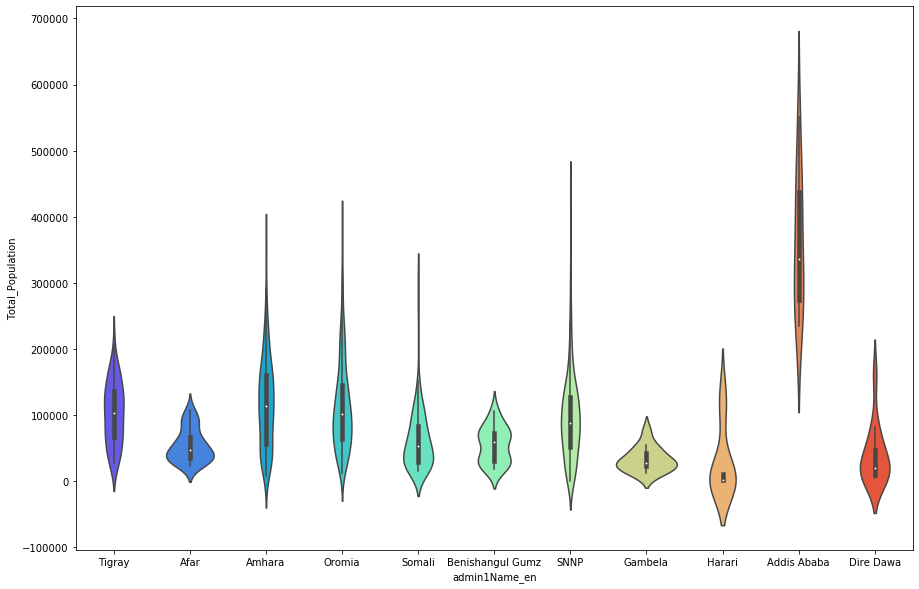

In [11]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.violinplot(x="admin1Name_en", y="Total_Population", data=Fulltable,palette='rainbow')
plt.show()

In [12]:
def CHOROMAP(DF,JSON,LOCATION,FEATUREKEY,COLOR,RANGE_L,RANGE_U, TITLE):
    Figure = px.choropleth_mapbox(DF, 
                        geojson=JSON, 
                        locations=LOCATION, featureidkey=FEATUREKEY,
                        color=COLOR,
                        color_continuous_scale="portland",
                        range_color=(RANGE_L, RANGE_U),
                        mapbox_style="carto-positron",
                        zoom=3, center = {"lat": 9, "lon": 39},
                        opacity=0.5,
                        hover_name='admin3Name_en',
                        hover_data=["admin1Name_en", "Total_Population", "Area_Km"],
                        labels={
                            'Population_Density':'Population Density',
                            'Total_Population':'Total Population',
                            'admin1Name_en':'Province',
                            'Area_Km':'Square Kilometer'
                        },
                        title = TITLE
                        )
    
    Figure.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return Figure

JSON_ON     = counties3
Location_ON = 'admin3Pcode'
Feature_ON  = 'properties.ADM3_PCODE'

Color_ON    = 'Total_Population'
Pop_Map = CHOROMAP(Fulltable,JSON_ON, Location_ON, Feature_ON, Color_ON, 25000, 300000,'Population')

Color_ON    = 'Population_Density'
Dens_Map = CHOROMAP(Fulltable,JSON_ON, Location_ON, Feature_ON, Color_ON, 50, 500,'Population Density')


In [13]:
plotly.offline.plot(Pop_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\Population.html')
plotly.offline.plot(Dens_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\Population Density.html')


'C:\\Users\\johnmeye\\Documents\\GitHub\\Ethiopia\\Plotly\\Population Density.html'

# Figuring out the site types

This is the step just prior to working out how many of each kind of router we will need. Now that we know about the different population densities; we can catagories them into the different catagories that they have provided for us. 

Catagories are: 
1. Dense-Urban
2. Urban
3. Sub-Urban
3. Rural
4. Deep-Rural

The result of this catagorising would be that the system would then know how the access type needs to be designed. The following image shows how they expect it to be.

![Microwave Connection](SiteConnection.png)

The breakdown would require then that there are specific rules in place for how many towers per catagory before we have a fibre connection. 

The Ethiopian Access Microwave network needs to ensure the highest level of stability. It is also important that network remains congestion free during failures. Therefore, the following guidelines should be adhered to:

1. Maximum of 4 Microwave Hops in a chain, 3 Hops in a chain according to capacities of the Vodafone calculator. The 4th hop (closest to the traditional BSC or aggregation backhaul point) needs to be protected. Plan for double the capacity required. These N+0 links must be used.
2. 5 Microwave sites in a star configuration (1st hop closest to the traditional BSC or aggregation point needs to be protected, planned for double capacity)
3. 4 Microwave Hops in chain protected by a full Microwave Ring 
4. 4 Microwave Hops in chain protected by a Mixed MW and Fibre Ring
5. Mesh topology with multiple aggregation points

The following image shows the planned layout of the network as per the Ethiotel backbone.

![Core Network](Core_Network.jpg)



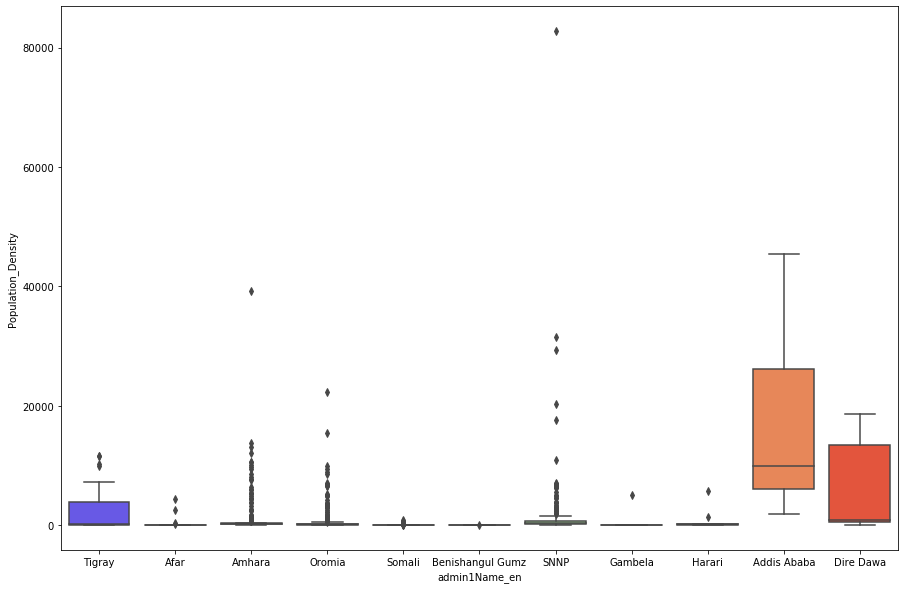

In [14]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.boxplot(x="admin1Name_en", y="Population_Density", data=Fulltable,palette='rainbow')


## Understanding the population density

The above figure shows that there is a some extremely dense portions of the country, Addis, Dire, Tigray, with some outlier towns in many of the other regions.

I suspect though that the towns might be showing as overly dense because rural people register at the towns and push up the numbers artificially. 

But we have two pieces of information which will help to decide what we do.

1. The population for a specific area
2. The calculated population density for an area which is calculated from the total country size and the region size.

Using these two together we should be able to place the regions into specific buckets. 

1. Dense Urban = Population Denser then 1000 people per km^2
2. Urban = Population Denser then 500 people but less then 1000 people per km^2
3. Sub-Urban = Population density between 175 and 500 people per km^2 (I updated this a bit because 200 was leaving out some key areas; many sites were on the 180-190 people/km^2 range)
4. Rural = Population density between 100 and 175 people per km^2
5. Deep-Rural = Population density less then 100 people per km^2

### Todo: Make this a dropdown so that we can select the range of each one to play around with it and figure out what is best.

In [15]:
DU_Thresh = 1000
U_Thresh = 400
SU_Thresh = 175
R_Thresh = 100
DR_Thresh = 0

def AREA_TYPE(Population_Density):
    if Population_Density >= DU_Thresh:
        return 'Dense Urban'
    elif U_Thresh <= Population_Density < DU_Thresh:
        return 'Urban'
    elif SU_Thresh <= Population_Density < U_Thresh:
        return 'Sub-Urban'    
    elif R_Thresh <= Population_Density < SU_Thresh:
        
        return 'Rural'
    else:
        return 'Deep Rural'

Fulltable['Area_Type'] = Fulltable.apply(lambda x: AREA_TYPE(x.Population_Density), axis=1)

# Using Area_Type to define what Routers will be needed

## Information available

The Choropleth map can not be subdivided into regions and sites. We have the information on the following to help make this decision

1. Population in an area
2. Size of an area
3. Type of area
4. Number of sites planned by vodacom for the area

## Site counts

Vodacom has given the number of sites it plans on a provincial level. But as can already be seen by the images above, the sites are extremely large and should be broken down further. Their methods they used was to break up the area types per year, Rural/Suburban etc... The question now comes in on how to approach this division. 

## Site connectivity
With this information we should be able to make the decision of how to split up the sites and how to connect them.

The breakdown is as follows:

1. For Rural and Deep Rural; the sites will all be MW linking back to the backhaul via MW sites. 
2. For Sub-Urban we will be able to have a mix of MW and Fibre, back to the nearest Urban location. Typically less then 80km away. 
3. For the Urbun and Dense-Urbun, we will be able to have fibre exclusively according to Vodacom planning.


In [16]:
#for i in Fulltable.admin1Name_en.unique():
#    
#    Area_Breakdown = Fulltable[Fulltable['admin1Name_en']== i]['Area_Type'].value_counts()
#    print(i)
#    print(Area_Breakdown)
#
# or simpler:

Area_Breakdown = Fulltable.groupby(['admin1Name_en','Area_Type']).count()
Area_Breakdown['admin3Name_en']

admin1Name_en     Area_Type  
Addis Ababa       Dense Urban     10
Afar              Deep Rural      31
                  Dense Urban      2
                  Sub-Urban        2
Amhara            Deep Rural      28
                  Dense Urban     38
                  Rural           67
                  Sub-Urban       46
                  Urban            4
Benishangul Gumz  Deep Rural      19
                  Rural            1
Dire Dawa         Dense Urban      6
                  Rural            2
                  Sub-Urban        1
                  Urban            4
Gambela           Deep Rural      14
                  Dense Urban      1
Harari            Deep Rural       4
                  Dense Urban      2
                  Rural            3
Oromia            Deep Rural      81
                  Dense Urban     39
                  Rural           88
                  Sub-Urban      110
                  Urban           17
SNNP              Deep Rural      26
        

In [17]:
dfDU = Fulltable[Fulltable['Area_Type']=='Dense Urban']
dfU = Fulltable[Fulltable['Area_Type']=='Urban']
dfSU = Fulltable[Fulltable['Area_Type']=='Sub-Urban']
dfR = Fulltable[Fulltable['Area_Type']=='Rural']
dfDR = Fulltable[Fulltable['Area_Type']=='Deep Rural']


In [18]:
def CHOROMAP(DF,JSON,LOCATION,FEATUREKEY,COLOR,RANGE_L,RANGE_U, TITLE):
    Figure = px.choropleth_mapbox(DF, 
                        geojson=JSON, 
                        locations=LOCATION, featureidkey=FEATUREKEY,
                        color=COLOR,
                        color_continuous_scale="portland",
                        range_color=(RANGE_L, RANGE_U),
                        mapbox_style="carto-positron",
                        zoom=3, center = {"lat": 9, "lon": 39},
                        opacity=0.5,
                        hover_name='admin3Name_en',
                        hover_data=["admin1Name_en", "Total_Population", "Area_Km"],
                        labels={
                            'Population_Density':'Population Density',
                            'Total_Population':'Total Population',
                            'admin1Name_en':'Province',
                            'Area_Km':'Square Kilometer'
                                },
                        title = TITLE
                          )
    
    Figure.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return Figure

JSON_ON     = counties3
Location_ON = 'admin3Pcode'
Feature_ON  = 'properties.ADM3_PCODE'
Color_ON    = 'Population_Density'

DU_Map = CHOROMAP(dfDU,JSON_ON, Location_ON, Feature_ON, Color_ON, DU_Thresh, 5000,'Dense Urban')
U_Map  = CHOROMAP(dfU,JSON_ON, Location_ON, Feature_ON, Color_ON, U_Thresh, DU_Thresh, 'Urban')
SU_Map = CHOROMAP(dfSU,JSON_ON, Location_ON, Feature_ON, Color_ON, SU_Thresh, U_Thresh, 'Sub Urban')
R_Map  = CHOROMAP(dfR,JSON_ON, Location_ON, Feature_ON, Color_ON, R_Thresh, SU_Thresh, 'Rural')
DR_Map = CHOROMAP(dfDR,JSON_ON, Location_ON, Feature_ON, Color_ON, DR_Thresh, R_Thresh, 'Deep Rural')



In [19]:
plotly.offline.plot(DU_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\DU_Map.html')
plotly.offline.plot(U_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\U_Map.html')
plotly.offline.plot(SU_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\SU_Map.html')
plotly.offline.plot(R_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\R_Map.html')
plotly.offline.plot(DR_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\DR_Map.html')

'C:\\Users\\johnmeye\\Documents\\GitHub\\Ethiopia\\Plotly\\DR_Map.html'

## Dividing the Cell Towers into regions

The challenge comes from the division of the towers up into the various areas. We know what areas are considered Urban/Sub-Urban and so forth. A choice must be made how to split each year's towers up.

The other choice would be if each area in the province should get a tower. In the deep rural sites this might not be entirely possible. 

For now the choice i will make is to divide the towers up proportionally to the amount of people who live in the specific province. Should this be an issue we can rework on this calculation again after meeting with Vodacom.

The total Sites keeps the information for the sites by year.



In [20]:
###
#So i found this section of code on StackExchange trying to figure out how to do this kind of calculation. 
#ultimately its quite complex to handle the multiple index's and locations to build out the sites. 
#This code works out the percentage of population in each province that lives in the specific Admin3 area.
#The sum of the percentages in each Admin3 will add to 100% in their respective Admin1 level.
###

Population_Grouping = Fulltable.groupby(['admin1Name_en','admin3Pcode']).agg({'Total_Population': 'sum'})
Population_PCT = Population_Grouping.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

Population_PCT.to_csv("Test1.csv", index=True)
Proportional = Population_PCT.reset_index() #If you want to convert back to a normal dataframe and not a Multi-Index frame.

#Making a Sites Rollout sheet to work out how to build out the sites.
Sites_Rollout = Fulltable[['admin1Name_en','admin3Pcode','admin3Name_en','Area_Type']]
Sites_Rollout.to_csv("Test2.csv", index=True)

Sites_Rollout = pd.merge(Sites_Rollout, TotalSites, how="left", on=["admin1Name_en"])

Sites_Rollout.to_csv("Test3.csv", index=True)

Sites_Rollout = pd.merge(Sites_Rollout, Proportional[['Total_Population','admin3Pcode']], how="left", on=["admin3Pcode"])



## Working out the Sites Rollout for a specific area

The challenge has always been to breakdown how the sites will be broken down. 

Below you will see there are two tables; the Sites_Rollout (Which was calculated by us with the help of understanding what the population grouping is), so this breaks the rollout into the specific Admin3 areas. I show both the admin1/admin3 grouping and the admin1 summation. 

The second one is the Table provided by Vodacom for this rollout. 

### Discrepencies

1. This occurs because i'm having to use some imprecise rounding on the populations. Because we are linking to the percentage of the population subgroup there will always be decimals. 

     a. The option exists to round-up as well; so sites which have below 0.5 sites scheduled for whatever reason would be able to get a site. But this might mean that we build into extremely remote regions. 
     

2. I adjusted the area of one or two of the areas in the admin3 area. This was because they had a NaN input but did have an area, so i calculated it; but it now makes some areas add up to more then 100%. Which is not a big problem for now. 


In [21]:
Sites_Rollout.groupby('admin1Name_en').sum()


,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Shape_Area_Admin1,Total,Total_Population
admin1Name_en,,,,,,,,,,,,,,
Addis Ababa,2820.0,0.0,0.0,0.0,0.0,940.0,680.0,1550.0,2530.0,260.0,60.0,0.443690,8840.0,100.0
Afar,2135.0,70.0,105.0,1295.0,1505.0,910.0,2380.0,1050.0,2345.0,770.0,2520.0,275.785335,15085.0,100.0
Amhara,66612.0,77226.0,49593.0,24339.0,11163.0,47214.0,41358.0,37332.0,37881.0,64782.0,75213.0,2360.966082,532713.0,100.0
Benishangul Gumz,560.0,0.0,40.0,420.0,580.0,720.0,760.0,680.0,960.0,60.0,640.0,82.986100,5420.0,100.0
Dire Dawa,572.0,0.0,0.0,0.0,0.0,221.0,260.0,390.0,221.0,52.0,78.0,1.127841,1794.0,100.0
Gambela,225.0,0.0,30.0,120.0,150.0,150.0,195.0,420.0,540.0,15.0,225.0,38.413650,2070.0,100.0
Harari,288.0,0.0,0.0,18.0,0.0,27.0,72.0,207.0,144.0,0.0,117.0,0.274608,873.0,100.0
Oromia,77385.0,138020.0,165825.0,173530.0,154435.0,161135.0,134000.0,139025.0,148405.0,181235.0,256610.0,8869.011100,1729605.0,100.0
SNNP,14416.0,27772.0,37948.0,54484.0,37948.0,26076.0,24380.0,18444.0,13356.0,81832.0,26924.0,1892.847936,363580.0,100.0


In [22]:
for column in Sites_Rollout.iloc[:, 4:15]:
    Sites_Rollout[column] =np.round(Sites_Rollout[column]*Sites_Rollout['Total_Population']/100)

Sites_Rollout['Total'] =Sites_Rollout.iloc[:, 4:15].sum(axis=1)


In [23]:
Sites_Rollout.replace(0, np.nan, inplace=True)

In [24]:
Sites_Rollout

,admin1Name_en,admin3Pcode,admin3Name_en,Area_Type,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Shape_Area_Admin1,Total,Total_Population
0,Tigray,ET010101,Tahtay Adiyabo,Deep Rural,1.0,NaN,2.0,3.0,NaN,3.0,2.0,2.0,2.0,1.0,1.0,4.399121,17.0,1.953604
1,Tigray,ET010102,Laelay Adiabo,Deep Rural,1.0,NaN,3.0,4.0,NaN,3.0,3.0,3.0,3.0,2.0,2.0,4.399121,24.0,2.380621
2,Tigray,ET010103,Medebay Zana,Rural,1.0,NaN,3.0,4.0,NaN,4.0,3.0,3.0,3.0,2.0,2.0,4.399121,25.0,2.727719
3,Tigray,ET010104,Tahtay Koraro,Rural,1.0,NaN,2.0,2.0,NaN,2.0,2.0,2.0,2.0,1.0,1.0,4.399121,15.0,1.445040
4,Tigray,ET010105,Asgede Tsimbila,Deep Rural,2.0,NaN,4.0,5.0,NaN,4.0,3.0,3.0,3.0,2.0,2.0,4.399121,28.0,3.031744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,Dire Dawa,ET150114,Police Maret,Urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.086757,NaN,0.952289
979,Dire Dawa,ET150201,Aseliso,Urban,6.0,NaN,NaN,NaN,NaN,2.0,3.0,4.0,2.0,1.0,1.0,0.086757,19.0,13.297425
980,Dire Dawa,ET150206,Jeldessa,Rural,4.0,NaN,NaN,NaN,NaN,2.0,2.0,3.0,2.0,NaN,1.0,0.086757,14.0,9.308961
981,Dire Dawa,ET150207,Wahil,Sub-Urban,3.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,1.0,NaN,NaN,0.086757,8.0,6.957731


In [25]:
Sites_Rollout.groupby(['admin1Name_en','Area_Type','admin3Name_en']).sum()

Year1  Year2  Year3  Year4  Year5  \
admin1Name_en Area_Type   admin3Name_en                                         
Addis Ababa   Dense Urban Addis Ketema       26.0    0.0    0.0    0.0    0.0   
                          Akaki - Kalit      18.0    0.0    0.0    0.0    0.0   
                          Arada              21.0    0.0    0.0    0.0    0.0   
                          Bole               33.0    0.0    0.0    0.0    0.0   
                          Gulele             27.0    0.0    0.0    0.0    0.0   
...                                           ...    ...    ...    ...    ...   
Tigray        Rural       Saesie Tsaedamba    2.0    0.0    4.0    5.0    0.0   
                          Tahtay Koraro       1.0    0.0    2.0    2.0    0.0   
                          Werei Leke          2.0    0.0    4.0    5.0    0.0   
              Sub-Urban   Ganta Afeshum       1.0    0.0    2.0    3.0    0.0   
                          Tahtay Mayechew     1.0    0.0    2.0    3.0    0.0   

                                            Year6  Year7  Year8  Year9  \
admin1Name_en Area_Type   admin3Name_en                                  
Addis Ababa   Dense Urban Addis Ketema        9.0    6.0   14.0   23.0   
                          Akaki - Kalit       6.0    4.0   10.0   17.0   
                          Arada               7.0    5.0   12.0   19.0   
                          Bole               11.0    8.0   18.0   29.0   
                          Gulele              9.0    7.0   15.0   24.0   
...                                           ...    ...    ...    ...   
Tigray        Rural       Saesie Tsaedamba    4.0    3.0    4.0    3.0   
                          Tahtay Koraro       2.0    2.0    2.0    2.0   
                          Werei Leke          4.0    3.0    4.0    4.0   
              Sub-Urban   Ganta Afeshum       2.0    2.0    2.0    2.0   
                          Tahtay Mayechew     3.0    2.0    2.0    2.0   

                                            Year10  Year11  Shape_Area_Admin1  \
admin1Name_en Area_Type   admin3Name_en                                         
Addis Ababa   Dense Urban Addis Ketema         2.0     1.0           0.044369   
                          Akaki - Kalit        2.0     0.0           0.044369   
                          Arada                2.0     0.0           0.044369   
                          Bole                 3.0     1.0           0.044369   
                          Gulele               2.0     1.0           0.044369   
...                                            ...     ...                ...   
Tigray        Rural       Saesie Tsaedamba     2.0     2.0           4.399121   
                          Tahtay Koraro        1.0     1.0           4.399121   
                          Werei Leke           2.0     2.0           4.399121   
              Sub-Urban   Ganta Afeshum        1.0     1.0           4.399121   
                          Tahtay Mayechew      1.0     1.0           4.399121   

                                            Total  Total_Population  
admin1Name_en Area_Type   admin3Name_en                              
Addis Ababa   Dense Urban Addis Ketema       81.0          9.143184  
                          Akaki - Kalit      57.0          6.548580  
                          Arada              66.0          7.574473  
                          Bole              103.0         11.621862  
                          Gulele             85.0          9.582584  
...                                           ...               ...  
Tigray        Rural       Saesie Tsaedamba   29.0          3.112297  
                          Tahtay Koraro      15.0          1.445040  
                          Werei Leke         30.0          3.232190  
              Sub-Urban   Ganta Afeshum      16.0          1.895229  
                          Tahtay Mayechew    17.0          1.977346  

[983 rows x 14 columns]

In [26]:
Sites_Rollout.groupby('Area_Type').sum()

,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Shape_Area_Admin1,Total,Total_Population
Area_Type,,,,,,,,,,,,,,
Deep Rural,335.0,138.0,188.0,276.0,230.0,286.0,345.0,296.0,367.0,240.0,463.0,5318.767162,3164.0,423.438388
Dense Urban,409.0,92.0,111.0,119.0,63.0,206.0,165.0,272.0,354.0,172.0,155.0,1996.294674,2118.0,319.734386
Rural,249.0,305.0,323.0,299.0,171.0,315.0,278.0,268.0,271.0,376.0,425.0,3625.102236,3280.0,155.786865
Sub-Urban,262.0,353.0,348.0,344.0,265.0,341.0,304.0,285.0,286.0,451.0,531.0,4128.231410,3770.0,129.246419
Urban,50.0,90.0,112.0,146.0,109.0,97.0,87.0,76.0,55.0,198.0,123.0,1203.419145,1143.0,71.793942


In [27]:
def CHOROMAP(DF,JSON,LOCATION,FEATUREKEY,COLOR,RANGE_L,RANGE_U, TITLE):
    Figure = px.choropleth_mapbox(DF, 
                        geojson=JSON, 
                        locations=LOCATION, featureidkey=FEATUREKEY,
                        color=COLOR,
                        color_continuous_scale="portland",
                        range_color=(RANGE_L, RANGE_U),
                        mapbox_style="carto-positron",
                        zoom=5, center = {"lat": 9, "lon": 39},
                        opacity=0.5,
                        hover_name='admin3Name_en',
                        hover_data=["admin1Name_en", "Year1", "Year2", "Year3","Year4", "Year5", "Year6" ],
                        labels={
                            'Population_Density':'Population Density',
                            'Total_Population':'Total Population',
                            'admin1Name_en':'Province',
                            'Area_Km':'Square Kilometer'
                                },
                        title = TITLE
                          )
    
    Figure.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return Figure

JSON_ON     = counties3
Location_ON = 'admin3Pcode'
Feature_ON  = 'properties.ADM3_PCODE'


for i in range(1,12):
    Color_ON    = 'Year'+str(i)
    Title       = "Rollout Year " + str(i)
    Saved       = r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\Sites_Rollout_Map'+str(i)+'.html'
    Sites_Rollout_Map = CHOROMAP(Sites_Rollout, JSON_ON, Location_ON, Feature_ON, Color_ON, 0, 5, Title)
    plotly.offline.plot(Sites_Rollout_Map, filename=Saved)



In [28]:
admin1Name_en_Sites_Rollout = Sites_Rollout.groupby('admin3Name_en').sum()
admin1Name_en_Sites_Rollout

,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Shape_Area_Admin1,Total,Total_Population
admin3Name_en,,,,,,,,,,,,,,
Aba 'Ala,2.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,7.879581,13.0,2.524103
Aba-korow,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,25.466707,4.0,0.475897
Ababo,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,26.474660,10.0,0.164213
Abadir,13.0,0.0,0.0,1.0,0.0,1.0,3.0,9.0,7.0,0.0,5.0,0.030512,39.0,40.688381
Abay Chomen,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,26.474660,10.0,0.179544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zabagazo,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.928528,2.0,0.244211
Zala,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,8.928528,9.0,0.477462
Zequala,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,12.901454,9.0,0.261980


## Dividing the sites up to calculate Fibre and MW site counts

We have already identified the sites numbers per region, divided up the deployment sites into the area.

The next step is to now divids the Area-types up. Technically the area_type is already available, but we would need to make some decisions around this. 

I have chosen to do the following:

1. Dense Urban and Urban are all Fibre Sites, so each site is 1:1 and Access Type switch with an NCS540.
2. The Sub-Urban sites will be some Fibre and Some MW, I will make an Assumption of 50:50 for this to start.
3. The Rural and Deep Rural sites are all MW. 

So we will have three dataframes to do these calculations.

In [29]:
Full_Fibre = Sites_Rollout[(Sites_Rollout['Area_Type']=='Urban') | (Sites_Rollout['Area_Type']=='Dense Urban') ]
Mixed = Sites_Rollout[(Sites_Rollout['Area_Type']=='Sub-Urban')]
Full_MW = Sites_Rollout[(Sites_Rollout['Area_Type']=='Rural') | (Sites_Rollout['Area_Type']=='Deep Rural') ]

In [30]:
Mixed

,admin1Name_en,admin3Pcode,admin3Name_en,Area_Type,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9,Year10,Year11,Shape_Area_Admin1,Total,Total_Population
13,Tigray,ET010206,Tahtay Mayechew,Sub-Urban,1.0,NaN,2.0,3.0,NaN,3.0,2.0,2.0,2.0,1.0,1.0,4.399121,17.0,1.977346
23,Tigray,ET010304,Ganta Afeshum,Sub-Urban,1.0,NaN,2.0,3.0,NaN,2.0,2.0,2.0,2.0,1.0,1.0,4.399121,16.0,1.895229
61,Afar,ET020198,Logiya-Semera,Sub-Urban,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,7.879581,6.0,1.473244
63,Afar,ET020202,Kunneba,Sub-Urban,2.0,NaN,NaN,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,7.879581,13.0,3.229053
96,Amhara,ET030202,Libokemekem,Sub-Urban,4.0,5.0,3.0,2.0,1.0,3.0,3.0,2.0,2.0,4.0,5.0,12.901454,34.0,1.204052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,SNNP,ET071801,Gachit,Sub-Urban,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0,1.0,8.928528,9.0,0.441100
924,SNNP,ET072003,Lanfero,Sub-Urban,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,8.928528,16.0,0.862294
926,SNNP,ET072005,Dalocha,Sub-Urban,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0,1.0,8.928528,9.0,0.551095
929,SNNP,ET072008,Wilbareg,Sub-Urban,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,2.0,1.0,8.928528,8.0,0.408021


In [31]:
Fibre_Rollout = pd.DataFrame() 
Fibre_Rollout['admin1Name_en']=Full_Fibre['admin1Name_en']
Fibre_Rollout['admin3Name_en']=Full_Fibre['admin3Name_en']
Fibre_Rollout['admin3Pcode']=Full_Fibre['admin3Pcode']
Fibre_Rollout['Area_Type']=Full_Fibre['Area_Type']

for column in Full_Fibre.loc[:, 'Year1':'Year11']:    
    Fibre_Column = 'Fibre'+str(column)
    Fibre_Rollout.loc[:,Fibre_Column] = Full_Fibre.loc[:,column]*1
for column in Full_Fibre.loc[:, 'Year1':'Year11']:    
    MW_Column = 'MW'+ str(column)
    Fibre_Rollout.loc[:,MW_Column] = np.nan


In [32]:
Mixed_Rollout = pd.DataFrame() 
Mixed_Rollout['admin1Name_en']=Mixed['admin1Name_en']
Mixed_Rollout['admin3Name_en']=Mixed['admin3Name_en']
Mixed_Rollout['admin3Pcode']=Mixed['admin3Pcode']
Mixed_Rollout['Area_Type']=Mixed['Area_Type']


for column in Mixed.loc[:, 'Year1':'Year11']:
    Fibre_Column = 'Fibre'+str(column)
    Mixed_Rollout.loc[:,Fibre_Column] = np.ceil(Mixed.loc[:,column]*0.5)
    
for column in Mixed.loc[:, 'Year1':'Year11']:
    MW_Column = 'MW'+ str(column)
    Mixed_Rollout.loc[:,MW_Column] = np.floor(Mixed.loc[:,column]*0.5)


In [33]:
MW_Rollout = pd.DataFrame() 
MW_Rollout['admin1Name_en']=Full_MW['admin1Name_en']
MW_Rollout['admin3Name_en']=Full_MW['admin3Name_en']
MW_Rollout['admin3Pcode']=Full_MW['admin3Pcode']
MW_Rollout['Area_Type']=Full_MW['Area_Type']

for column in Full_MW.loc[:, 'Year1':'Year11']:
    Fibre_Column = 'Fibre'+str(column)
    MW_Rollout.loc[:,Fibre_Column] = np.nan

for column in Full_MW.loc[:, 'Year1':'Year11']:
    MW_Column = 'MW'+ str(column)
    MW_Rollout.loc[:,MW_Column] = Full_MW.loc[:,column]*1   
    


## Microwave as an option

If there is active sharing on a site; without applying, shaping and managing bandwidth; Microwave is extremely limited in its ability to share the network. 

Ethiotel is requesting that this is enforced. 

The request is that this is an end to end IP. So we must assume that the MW can Guaranty QoS fidelity for Vodafone and the sharing partner. 

The main issue will come with the requirement for the sharing. If there is an enterprise customer for example; how will they connect this enterprise to a vpn and the microwave. 


In [34]:
Mixed_Rollout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 13 to 981
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   admin1Name_en  215 non-null    object 
 1   admin3Name_en  215 non-null    object 
 2   admin3Pcode    215 non-null    object 
 3   Area_Type      215 non-null    object 
 4   FibreYear1     157 non-null    float64
 5   FibreYear2     189 non-null    float64
 6   FibreYear3     194 non-null    float64
 7   FibreYear4     202 non-null    float64
 8   FibreYear5     167 non-null    float64
 9   FibreYear6     193 non-null    float64
 10  FibreYear7     194 non-null    float64
 11  FibreYear8     179 non-null    float64
 12  FibreYear9     169 non-null    float64
 13  FibreYear10    202 non-null    float64
 14  FibreYear11    199 non-null    float64
 15  MWYear1        157 non-null    float64
 16  MWYear2        189 non-null    float64
 17  MWYear3        194 non-null    float64
 18  MWYear4  

In [35]:
Combined_MW_Rollout = pd.DataFrame()
Combined_MW_Rollout = Combined_MW_Rollout.append(MW_Rollout)
Combined_MW_Rollout = Combined_MW_Rollout.append(Mixed_Rollout)
Combined_MW_Rollout = Combined_MW_Rollout.drop(Combined_MW_Rollout.columns.to_series()["FibreYear1":"FibreYear11"], axis=1)
Combined_MW_Rollout.loc[:,'Total']= Combined_MW_Rollout.loc[:,'MWYear1':'MWYear11'].sum(numeric_only=True, axis=1)

Combined_Fibre_Rollout = pd.DataFrame()
Combined_Fibre_Rollout = Combined_Fibre_Rollout.append(Fibre_Rollout)
Combined_Fibre_Rollout = Combined_Fibre_Rollout.append(Mixed_Rollout)
Combined_Fibre_Rollout = Combined_Fibre_Rollout.drop(Combined_MW_Rollout.columns.to_series()["MWYear1":"MWYear11"], axis=1)
Combined_Fibre_Rollout.loc[:,'Total']= Combined_Fibre_Rollout.loc[:,'FibreYear1':'FibreYear11'].sum(numeric_only=True, axis=1)

In [36]:
Combined_MW_Rollout.groupby('admin3Name_en').sum()


,MWYear1,MWYear2,MWYear3,MWYear4,MWYear5,MWYear6,MWYear7,MWYear8,MWYear9,MWYear10,MWYear11,Total
admin3Name_en,,,,,,,,,,,,
Aba 'Ala,2.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,13.0
Aba-korow,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0
Ababo,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0
Abay Chomen,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0
Abaya,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Yubdo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zabagazo,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
Zala,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,9.0


In [37]:
Combined_Fibre_Rollout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 6 to 981
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   admin1Name_en  471 non-null    object 
 1   admin3Name_en  471 non-null    object 
 2   admin3Pcode    471 non-null    object 
 3   Area_Type      471 non-null    object 
 4   FibreYear1     264 non-null    float64
 5   FibreYear2     316 non-null    float64
 6   FibreYear3     346 non-null    float64
 7   FibreYear4     361 non-null    float64
 8   FibreYear5     288 non-null    float64
 9   FibreYear6     345 non-null    float64
 10  FibreYear7     336 non-null    float64
 11  FibreYear8     304 non-null    float64
 12  FibreYear9     272 non-null    float64
 13  FibreYear10    385 non-null    float64
 14  FibreYear11    367 non-null    float64
 15  Total          471 non-null    float64
dtypes: float64(12), object(4)
memory usage: 62.6+ KB


In [38]:
def CHOROMAP(DF,JSON,LOCATION,FEATUREKEY,COLOR,RANGE_L,RANGE_U, TITLE):
    Figure = px.choropleth_mapbox(DF, 
                        geojson=JSON, 
                        locations=LOCATION, featureidkey=FEATUREKEY,
                        color=COLOR,
                        color_continuous_scale="portland",
                        range_color=(RANGE_L, RANGE_U),
                        mapbox_style="carto-positron",
                        zoom=3, center = {"lat": 9, "lon": 39},
                        opacity=0.5,
                        hover_name='admin3Name_en',
                        hover_data=["admin1Name_en"],
                        labels={
                            'Population_Density':'Population Density',
                            'Total_Population':'Total Population',
                            'admin1Name_en':'Province',
                            'Area_Km':'Square Kilometer'
                                },
                        title = TITLE
                          )
    
    Figure.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return Figure

JSON_ON     = counties3
Location_ON = 'admin3Pcode'
Feature_ON  = 'properties.ADM3_PCODE'
Color_ON    = 'Total'

Fibre_Map = CHOROMAP(Combined_Fibre_Rollout,JSON_ON, Location_ON, Feature_ON, Color_ON, 1, 25, 'Fibre')
MW_Map = CHOROMAP(Combined_MW_Rollout,JSON_ON, Location_ON, Feature_ON, Color_ON, 1, 30, 'MW')


In [39]:
plotly.offline.plot(Fibre_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\Fibre_Map.html')
plotly.offline.plot(MW_Map, filename=r'C:\Users\johnmeye\Documents\GitHub\Ethiopia\Plotly\MW_Map.html')

'C:\\Users\\johnmeye\\Documents\\GitHub\\Ethiopia\\Plotly\\MW_Map.html'